# Prerequisites

In [1]:
import sys

sys.path.append("..")

In [2]:
%load_ext autoreload
%autoreload 2

import argparse
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from IPython.display import display
from skimage.morphology import binary_erosion
from tqdm.notebook import tqdm

from dataset import (
    HWSetNoise,
    get_dloader,
    normalize_hw,
    normalize_hw_mask,
    normalize_inv_hw,
    normalize_inv_hw_mask,
    transform_shared,
)
from dataset3d import BNSetNoise, get_dloader_noise
from util import show_imarray
from util3d import show_volume

# sns.set_theme()

In [6]:
data_dir = "../data"
fig_dir = "../figures"

# 2D fourier transform

General idea: Images, like other signals, can be decomposed into sine/cosine waves. This is done via a fourier transform. When the complete signal is not available, e.g. in every case where we have an image with a finite number of pixels, we use the discrete fourier transform. 

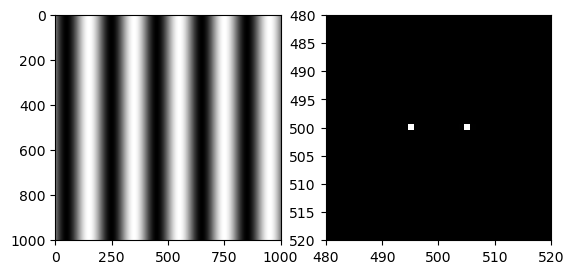

In [7]:
# https://thepythoncodingbook.com/2021/08/30/2d-fourier-transform-in-python-and-fourier-synthesis-of-images/
x = np.arange(-500, 501, 1)
X, Y = np.meshgrid(x, x)
wavelength = 200
angle = 0
grating = np.sin(
    2*np.pi*(X*np.cos(angle) + Y*np.sin(angle)) / wavelength
)
plt.set_cmap("gray")
plt.subplot(121)
plt.imshow(grating)
# Calculate Fourier transform of grating
ft = np.fft.ifftshift(grating)
ft = np.fft.fft2(ft)
ft = np.fft.fftshift(ft)
plt.subplot(122)
plt.imshow(abs(ft))
plt.xlim([480, 520])
plt.ylim([520, 480])  # Note, order is reversed for y
plt.show()

In [9]:
dset = HWSetNoise(data_dir, "val")

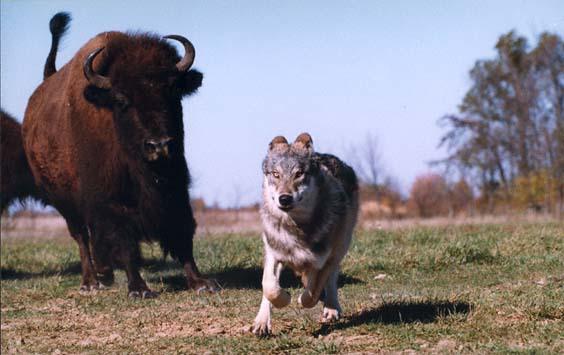

In [42]:
img, label, mask, noise = dset[1]
noise = noise.numpy()
img

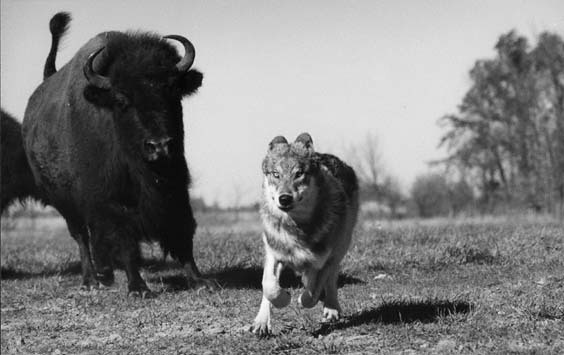

In [43]:
img_g = img.convert('L')
img_g

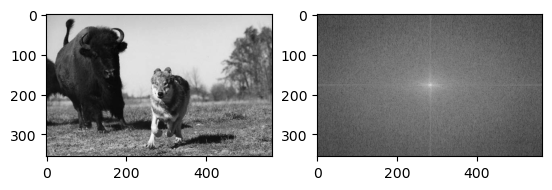

In [44]:
# Calculate Fourier transform of image
ft = np.fft.ifftshift(np.array(img_g) / 255.0)
ft = np.fft.fft2(ft)
ft = np.fft.fftshift(ft)
plt.subplot(121)
plt.imshow(img_g)

plt.subplot(122)
# plt.imshow(np.log(abs(ft)[150:-150, 250:-250]))
plt.imshow(np.log(abs(ft)))
# plt.xlim([480, 520])
# plt.ylim([520, 480])  # Note, order is reversed for y
plt.show()

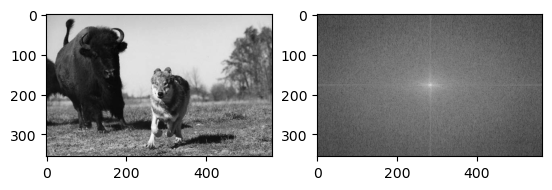

In [45]:
# Calculate Fourier transform of image
ft = np.fft.ifftshift(np.array(img_g) / 255.0)
ft = np.fft.fft2(ft)
ft = np.fft.fftshift(ft)
plt.subplot(121)
plt.imshow(img_g)

plt.subplot(122)
# plt.imshow(np.log(abs(ft)[150:-150, 250:-250]))
plt.imshow(np.log(abs(ft)))
# plt.xlim([480, 520])
# plt.ylim([520, 480])  # Note, order is reversed for y
plt.show()

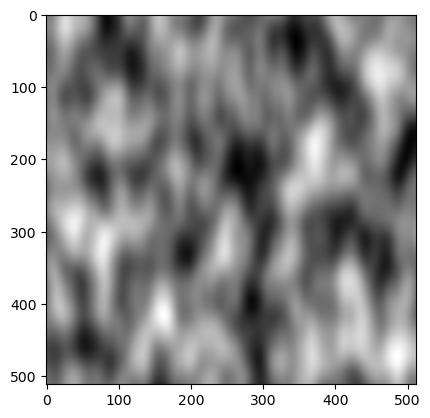

In [48]:
show_imarray(noise[0])

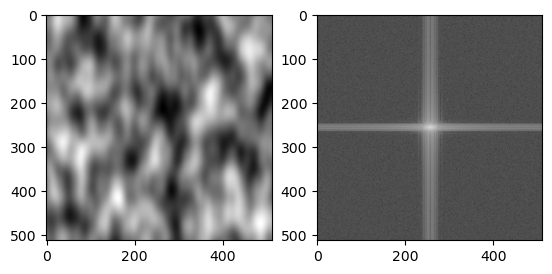

In [61]:
# Calculate Fourier transform of image
ft = np.fft.ifftshift(np.array(noise[0]) / 255.0)
ft = np.fft.fft2(ft)
ft = np.fft.fftshift(ft)
plt.subplot(121)
plt.imshow(noise[0])

plt.subplot(122)
# plt.imshow(np.log(abs(ft)[150:-150, 250:-250]))
plt.imshow(np.log(abs(ft)))
# plt.xlim([480, 520])
# plt.ylim([520, 480])  # Note, order is reversed for y
plt.show()

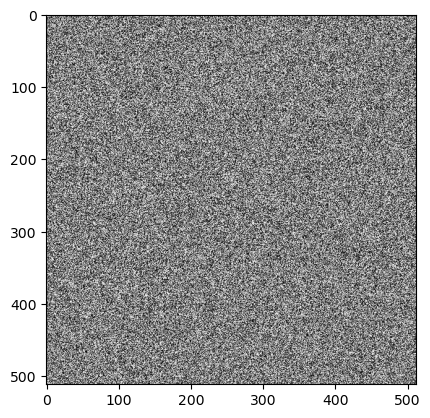

In [58]:
u_noise = np.random.uniform(size=noise.shape[-2:])
plt.imshow(u_noise);

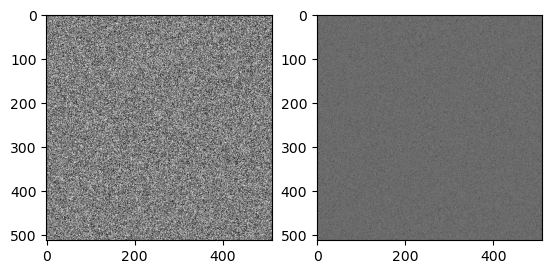

In [59]:
# Calculate Fourier transform of image
ft = np.fft.ifftshift(np.array(u_noise))
ft = np.fft.fft2(ft)
ft = np.fft.fftshift(ft)
plt.subplot(121)
plt.imshow(u_noise)

plt.subplot(122)
# plt.imshow(np.log(abs(ft)[150:-150, 250:-250]))
plt.imshow(np.log(abs(ft)))
# plt.xlim([480, 520])
# plt.ylim([520, 480])  # Note, order is reversed for y
plt.show()

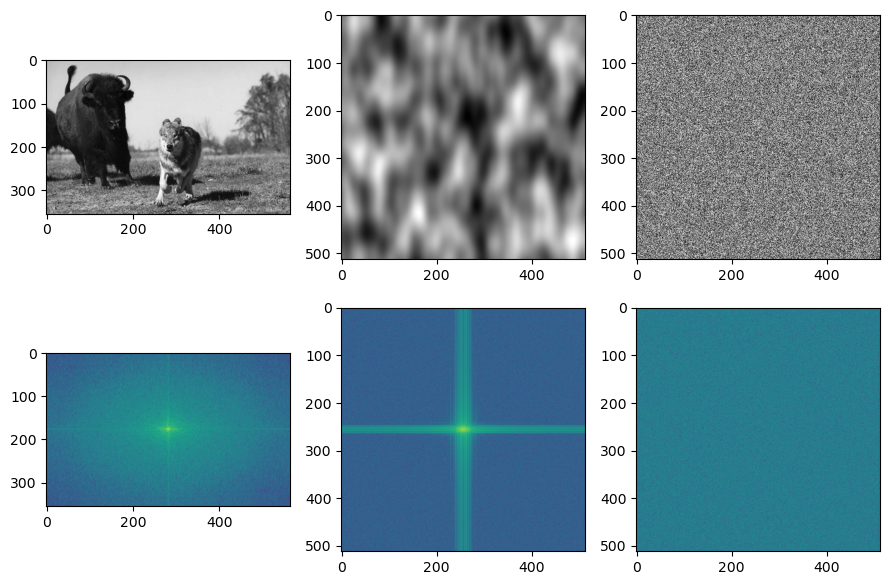

In [64]:
fig, (axs0, axs1) = plt.subplots(2, 3, figsize=(9, 6), tight_layout=True)
imgs = np.array(img_g) / 255.0, np.array(noise[0]) / 255.0, u_noise

for img, ax in zip(imgs, axs0):
    ax.imshow(img, cmap='gray')

for img, ax in zip(imgs, axs1):
    ft = np.fft.ifftshift(img)
    ft = np.fft.fft2(ft)
    ft = np.fft.fftshift(ft)

    ax.imshow(np.log(abs(ft)), cmap='viridis')